# Predict Hike/Keep/Lower from FOMC documents
## Prep work
### Install/Import necessary libraries

In [21]:
!pip install tensorflow==2.0.1
!pip install tensorflow_hub
!pip install sentencepiece

Looking in links: https://files.pythonhosted.org/
Looking in links: https://files.pythonhosted.org/
Looking in links: https://files.pythonhosted.org/


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from collections import defaultdict
from collections import Counter

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

plt.style.use('ggplot')
stop = set(stopwords.words('english'))

import datetime as dt
import re
import pickle
from tqdm import tqdm_notebook

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
import tokenization

[nltk_data] Downloading package stopwords to /Users/yuki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
logger = logging.getLogger('mylogger')
logger.setLevel(logging.DEBUG)
timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)

NameError: name 'logging' is not defined

In [ ]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

### Load Train Set

In [12]:
# Load data
file = open('../data/FOMC/train_split_df.pickle', 'rb')

df = pickle.load(file)
file.close()

df

,contents,rate,stmt_date,target,type,target_lower,target_hold,target_raise
Date,,,,,,,,
1994-02-04,Chairman Alan Greenspan announced today that t...,3.25,1994-02-04,1,statement,0,0,1
1994-03-22,The Board approved an increase in the discount...,3.50,1994-03-22,1,statement,0,0,1
1994-04-18,Chairman Alan Greenspan announced today that t...,3.75,1994-04-18,1,statement,0,0,1
1994-05-17,"In a related move, the Federal Open Market Com...",4.25,1994-05-17,1,statement,0,0,1
1994-08-16,These measures were taken against the backgrou...,4.75,1994-08-16,1,statement,0,0,1
1994-11-15,Chairman Alan Greenspan announced today that t...,5.50,1994-11-15,1,statement,0,0,1
1995-02-01,Chairman Alan Greenspan announced today that t...,6.00,1995-02-01,1,statement,0,0,1
1995-07-06,"In a related move, the Federal Open Market Com...",5.75,1995-07-06,-1,statement,1,0,0
1995-12-19,Chairman Alan Greenspan announced today that t...,5.50,1995-12-19,-1,statement,1,0,0


## EDA

Text(0, 0.5, 'number of samples')

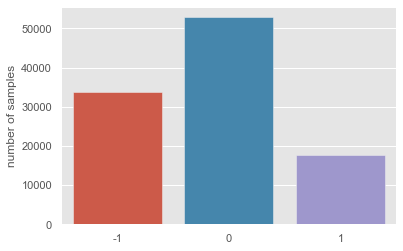

In [4]:
x = df.target.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('number of samples')

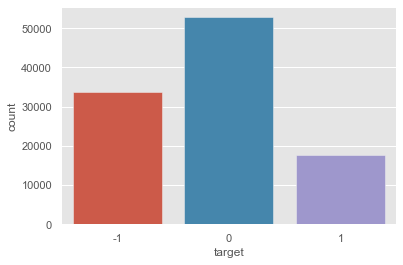

In [5]:
sns.countplot(x='target', data=df)

In [6]:
def create_corpus(target):
    corpus = []
    
    for x in df[df['target']==target]['contents'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def get_frequent_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

Text(0.5, 1.0, 'Raise')

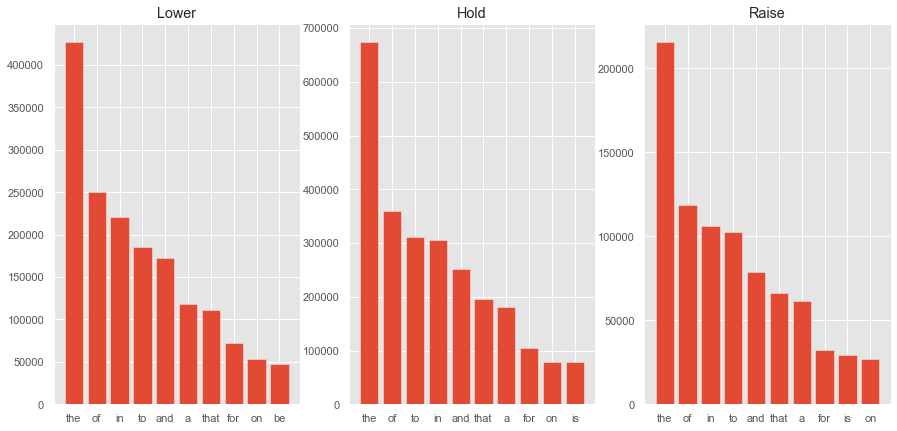

In [7]:
# Most frequent words
corpus_lower = create_corpus(-1)
corpus_hold = create_corpus(0)
corpus_raise = create_corpus(1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
x, y = get_frequent_words(corpus_lower)
ax1.bar(x, y)
ax1.set_title('Lower')
x, y = get_frequent_words(corpus_hold)
ax2.bar(x, y)
ax2.set_title('Hold')
x, y = get_frequent_words(corpus_raise)
ax3.bar(x, y)
ax3.set_title('Raise')

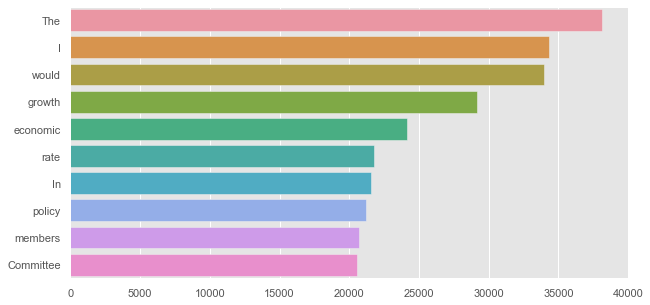

In [8]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus_lower)
most = counter.most_common()
x, y = [], []
for word, count in most[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(10,5))
sns.barplot(x=y, y=x)

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,15))
contents_len = df[df['type'] == 'statement']['word_count']
ax1.hist(contents_len, color='red', bins=100, range=(0,20000))
ax1.set_title('Statement')
contents_len = df[df['type'] == 'minutes']['word_count']
ax2.hist(contents_len, color='green', bins=100, range=(0,20000))
ax2.set_title('Minutes')
contents_len = df[df['type'] =='script']['word_count']
ax3.hist(contents_len, color='blue', bins=100, range=(0,60000))
ax3.set_title('Script')
contents_len = df[df['type'] =='speech']['word_count']
ax4.hist(contents_len, color='brown', bins=100, range=(0,20000))
ax4.set_title('Speech')


## Tokenize

In [13]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [14]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    #_, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    #clf_output = sequence_output[:, 0, :]
    #out = Dense(3, activation='softmax')(clf_output)
    
    _, bert_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = bert_output[:, 0, :]
    out = Dense(3, activation='softmax')(clf_output) 
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [15]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

OSError: SavedModel file does not exist at: /var/folders/f9/1jftrqkj5k53vpq9f2m9ltyw0000gn/T/tfhub_modules/88ac13afec2955fd14396e4582c251841b67429a/{saved_model.pbtxt|saved_model.pb}

In [16]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

NameError: name 'bert_layer' is not defined

In [ ]:
# Check how BERT tokenizer tokenizes a text
sample = df.contents.values[0]
print(sample)
sample_tokenize = tokenizer.tokenize(sample)
sample_tokenize

In [ ]:
#train_df = df.loc[df['type'].isin(['statement', 'minutes', 'script'])]
train_df = df.loc[df['type'].isin(['statement'])]

In [ ]:
train_input = bert_encode(train_df.contents.values, tokenizer, max_len=512)
train_labels = train_df[['target_lower', 'target_hold', 'target_raise']].values

In [ ]:
list(tokenizer.vocab.keys())[5000:5020]

In [ ]:
model = build_model(bert_layer, max_len=512)
model.summary()

In [ ]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=16
)

model.save('model.h5')

In [ ]:
test_df = train_df[train_df.index > '2019-01-01']
test_input = bert_encode(test_df.contents.values, tokenizer, max_len=512)

In [ ]:
train_input

In [ ]:
test_input

In [ ]:
pred = model.predict(test_input)

In [ ]:
!pip list | grep tensor